# OLIST E-Commerce Sales & Delivery Analysis (Python)

## Business Objective
Analyze sales performance, customer behavior, product contribution, and delivery efficiency using Python to generate actionable business insights.

## Tools Used
- Python (Pandas, NumPy)
- Matplotlib & Seaborn
- Jupyter Notebook

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

## Data Loading

Load all raw datasets and inspect structure before cleaning.

In [3]:
# Load datasets

orders = pd.read_csv("../data/olist_orders_dataset.csv")
payments = pd.read_csv("../data/olist_order_payments_dataset.csv")
customers = pd.read_csv("../data/olist_customers_dataset.csv")
reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv")
items = pd.read_csv("../data/olist_order_items_dataset.csv")
products = pd.read_csv("../data/olist_products_dataset.csv")
sellers = pd.read_csv("../data/olist_sellers_dataset.csv")
geolocation = pd.read_csv("../data/olist_geolocation_dataset.csv")
category_translation = pd.read_csv("../data/product_category_name_translation.csv")


In [4]:
orders.head()
orders.info()
orders.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

## Data Cleaning & Feature Engineering

- Converted datetime columns
- Created delivery_days
- Created day_type (Weekday vs Weekend)
- Created delivery_status
- Aggregated order-level payments

In [ ]:
# Convert date columns.

orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

In [6]:
# Removed Time

orders['order_date'] = orders['order_purchase_timestamp'].dt.date

In [7]:
# Weekday vs Weekend

orders['day_type'] = np.where(
    orders['order_purchase_timestamp'].dt.dayofweek >= 5,
    'Weekend',
    'Weekday'
)

In [8]:
# Delivery Days

orders['delivery_days'] = (
    orders['order_delivered_customer_date'] -
    orders['order_purchase_timestamp']
).dt.days

In [9]:
# Delivery Status

orders['delivery_status'] = np.where(
    orders['order_status'] == 'delivered',
    'Delivered',
    'Not Delivered'
)

In [12]:
#Aggregate Payments
## Now each order has one payment value.

payment_agg = payments.groupby('order_id')['payment_value'].sum().reset_index()
payment_agg.rename(columns={'payment_value': 'total_payment'}, inplace=True)

## Order-Level Analytical Dataset

Merged orders, payments, customers, and reviews to create a single analysis-ready dataframe.

In [11]:
# Merge with Orders - Main fact table.

order_fact = orders.merge(payment_agg, on='order_id', how='left')

In [13]:
# Add Customer State

order_fact = order_fact.merge(
    customers[['customer_id', 'customer_state']],
    on='customer_id',
    how='left'
)

In [14]:
# Add Review Score

order_fact = order_fact.merge(
    reviews[['order_id', 'review_score']],
    on='order_id',
    how='left'
)

In [15]:
# View Fact Table

order_fact.head()
order_fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99992 non-null  object        
 1   customer_id                    99992 non-null  object        
 2   order_status                   99992 non-null  object        
 3   order_purchase_timestamp       99992 non-null  datetime64[ns]
 4   order_approved_at              99831 non-null  object        
 5   order_delivered_carrier_date   98199 non-null  object        
 6   order_delivered_customer_date  97005 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99992 non-null  object        
 8   order_date                     99992 non-null  object        
 9   day_type                       99992 non-null  object        
 10  delivery_days                  97005 non-null  float64       
 11  delivery_status

# Build KPIs

## Key Performance Indicators (KPIs)

In [16]:
# KPI 1 — Total Revenue

total_revenue = order_fact['total_payment'].sum()
total_revenue

np.float64(16081420.74)

In [17]:
# KPI 2 — Total Orders

total_orders = order_fact['order_id'].nunique()
total_orders

99441

In [18]:
# KPI 3 — Average Order Value

aov = total_revenue / total_orders
aov

np.float64(161.71821220623283)

In [19]:
# KPI 4 — Orders by Delivery Status

order_fact['delivery_status'].value_counts()

delivery_status
Delivered        97007
Not Delivered     2985
Name: count, dtype: int64

In [20]:
# KPI 5 — Average Delivery Days

order_fact['delivery_days'].mean()

np.float64(12.100015463120458)

# Visualization

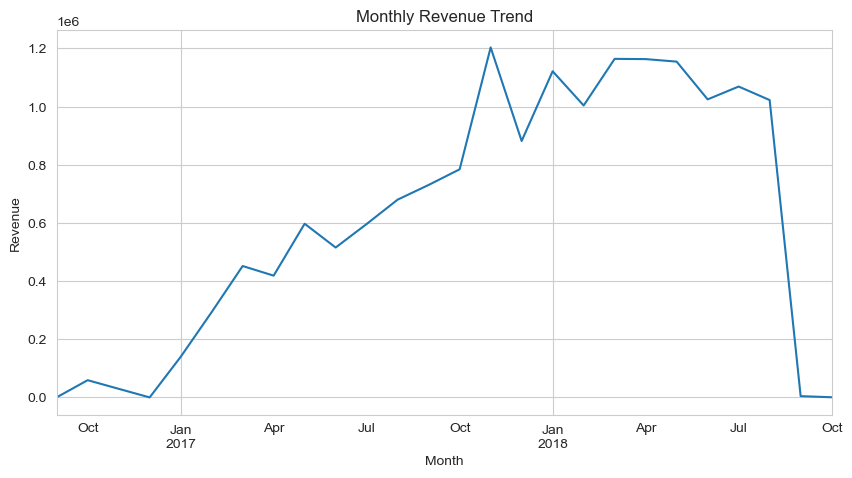

In [21]:
monthly_revenue = order_fact.groupby(
    order_fact['order_purchase_timestamp'].dt.to_period('M')
)['total_payment'].sum()

monthly_revenue.plot(figsize=(10,5))
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

# Exploratory Data Analysis (EDA)

### 1 Business Health Check

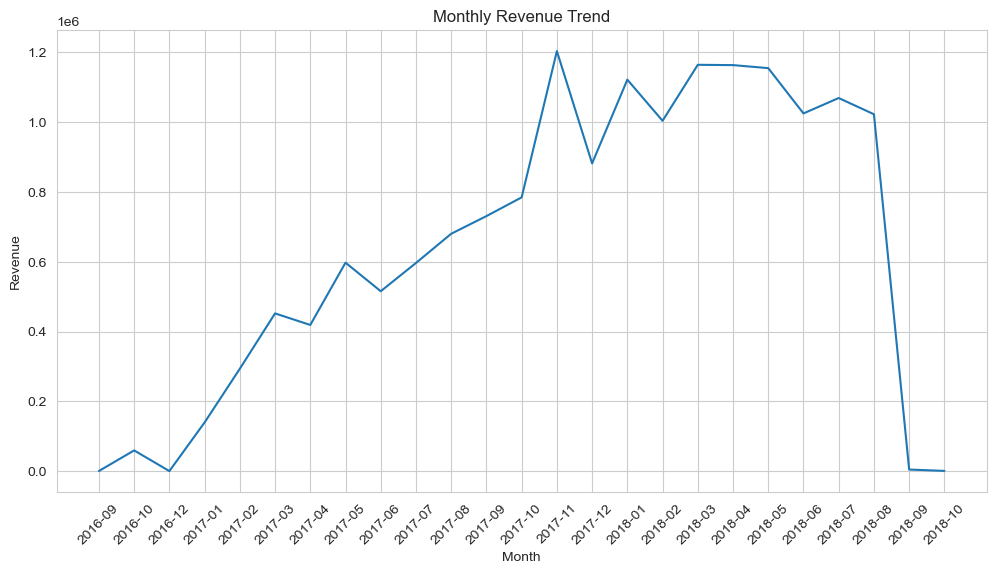

In [22]:
# Revenue Trend Over Time

monthly_revenue = order_fact.groupby(
    order_fact['order_purchase_timestamp'].dt.to_period('M')
)['total_payment'].sum().reset_index()

monthly_revenue['order_purchase_timestamp'] = monthly_revenue['order_purchase_timestamp'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue,
             x='order_purchase_timestamp',
             y='total_payment')

plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()

### 2 Weekday vs Weekend Sales

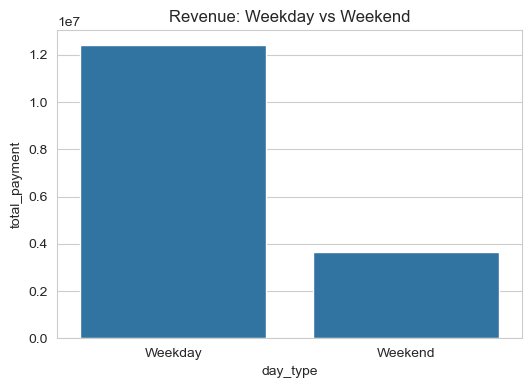

In [23]:
# When do customers shop more?

day_revenue = order_fact.groupby('day_type')['total_payment'].sum().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=day_revenue,
            x='day_type',
            y='total_payment')

plt.title("Revenue: Weekday vs Weekend")
plt.show()

### 3 Delivery Performance

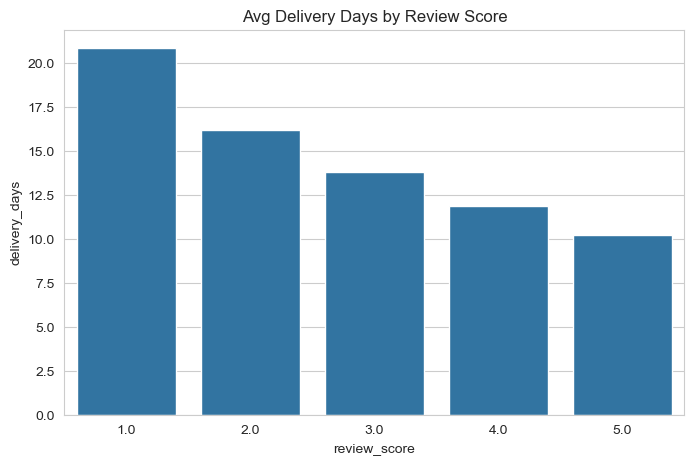

In [24]:
# Delivery Days vs Review Score

delivery_review = order_fact.groupby('review_score')['delivery_days'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=delivery_review,
            x='review_score',
            y='delivery_days')

plt.title("Avg Delivery Days by Review Score")
plt.show()

### 4 Top Customer States

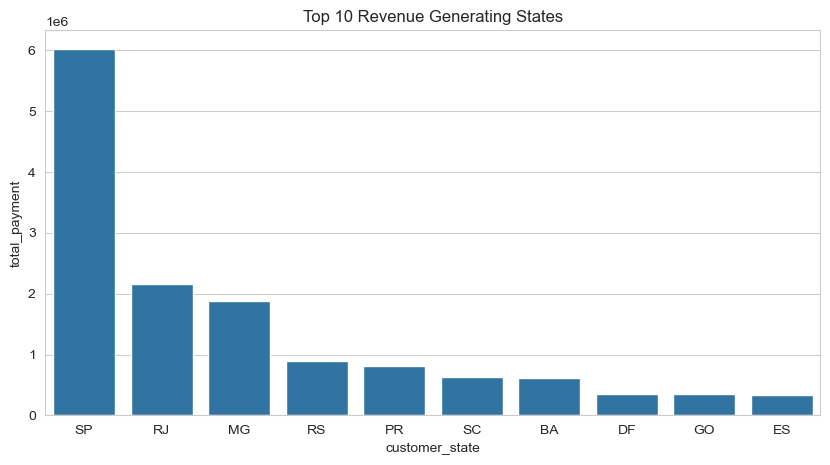

In [25]:
# Where is revenue coming from?

top_states = order_fact.groupby('customer_state')['total_payment'].sum().reset_index()
top_states = top_states.sort_values(by='total_payment', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top_states,
            x='customer_state',
            y='total_payment')

plt.title("Top 10 Revenue Generating States")
plt.show()

### 5 Payment Type Distribution

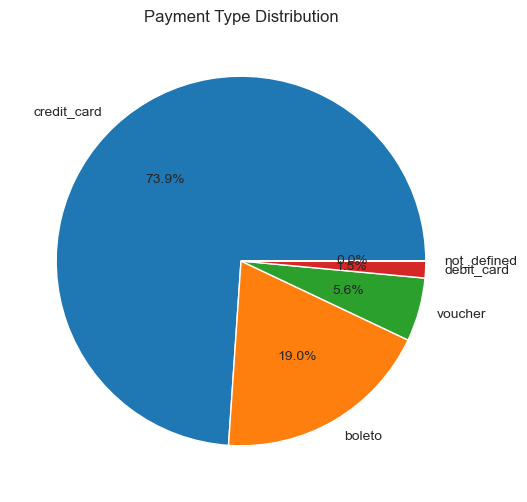

In [26]:
# How do customers prefer to pay?

payment_type_counts = payments['payment_type'].value_counts()

plt.figure(figsize=(6,6))
payment_type_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Payment Type Distribution")
plt.ylabel("")
plt.show()

# 10 Product Revenue Analysis

In [ ]:
# 1 - Merge order_items with payment aggregation

product_data = items.merge(payment_agg, on='order_id', how='left')

In [28]:
# 2 - Calculate Product Revenue Properly

items['total_product_revenue'] = items['price'] + items['freight_value']

In [ ]:
# 2.2Calculate product revenue:

product_revenue = items.groupby('product_id')['total_product_revenue'].sum().reset_index()
product_revenue = product_revenue.sort_values(by='total_product_revenue', ascending=False)

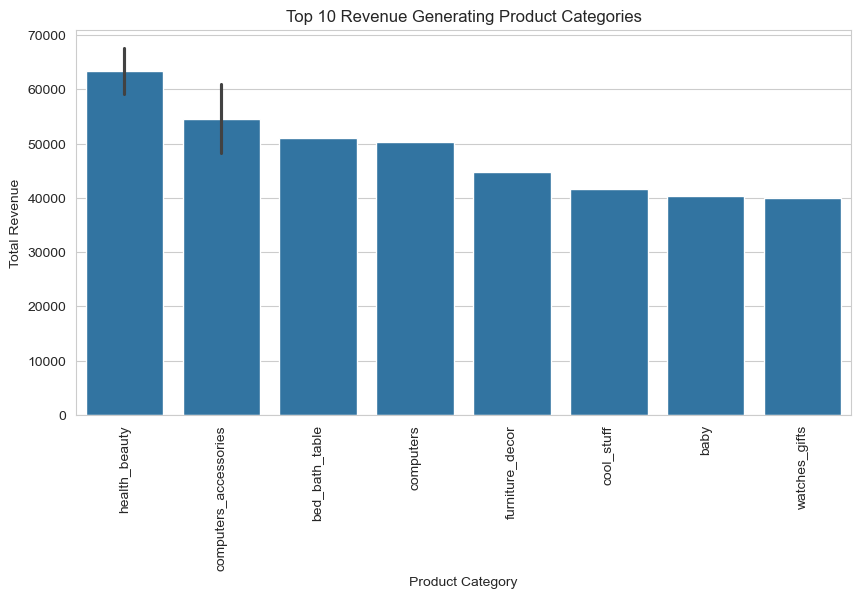

In [ ]:
# 3 - Top 10 Products

# top_products = product_revenue.head(10)

# plt.figure(figsize=(10,5))
# sns.barplot(data=top_products,
#             x='product_id',
#             y='total_product_revenue')

# plt.xticks(rotation=90)
# plt.title("Top 10 Revenue Generating Products")
# plt.show()



# Top 10 by product category name.

product_revenue = (
    items.groupby("product_id", as_index=False)["total_product_revenue"]
    .sum()
)

top_products = (
    product_revenue
    .merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
    .merge(category_translation, on="product_category_name", how="left")
    .assign(product_label=lambda d: d["product_category_name_english"].fillna(d["product_category_name"]))
    .sort_values("total_product_revenue", ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_products,
    x="product_label",
    y="total_product_revenue"
)

plt.xticks(rotation=90)
plt.title("Top 10 Revenue Generating Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Total Revenue")
plt.show()


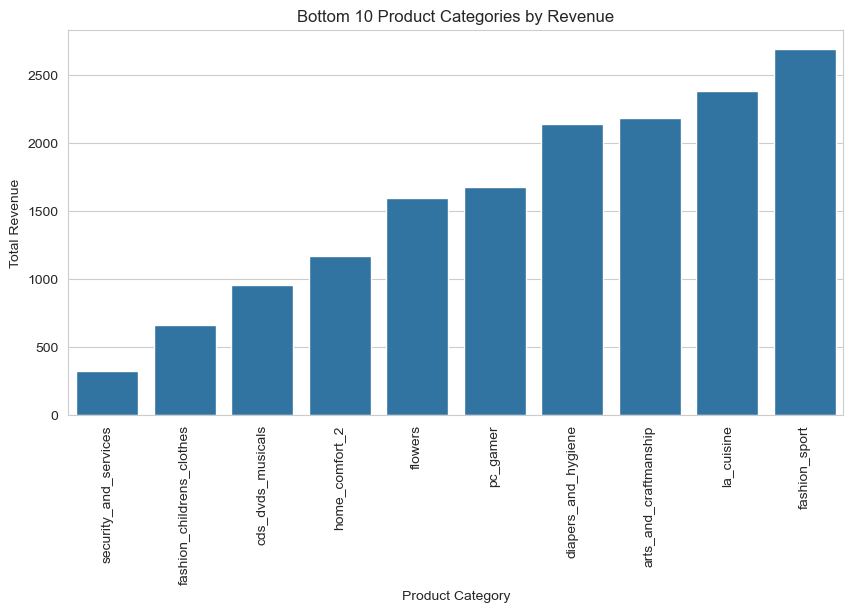

In [32]:
# 4 - Bottom 10 Products

# Bottom 10 product categories by total revenue

product_revenue = (
    items.groupby("product_id", as_index=False)["total_product_revenue"]
    .sum()
)

bottom_products = (
    product_revenue
    .merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
    .merge(category_translation, on="product_category_name", how="left")
    .assign(product_label=lambda d: d["product_category_name_english"].fillna(d["product_category_name"]))
    .groupby("product_label", as_index=False)["total_product_revenue"].sum()
    .sort_values("total_product_revenue", ascending=True)
    .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=bottom_products,
    x="product_label",
    y="total_product_revenue"
)

plt.xticks(rotation=90)
plt.title("Bottom 10 Product Categories by Revenue")
plt.xlabel("Product Category")
plt.ylabel("Total Revenue")
plt.show()


## Key Business Insights

1. Revenue shows consistent growth with peak seasonal months.
2. Weekday sales outperform weekend sales.
3. Delivery delays negatively impact review scores.
4. Revenue is concentrated among top-performing products.
5. Certain states dominate overall sales contribution.

## Conclusion

This project demonstrates end-to-end data analysis using Python, including data cleaning, feature engineering, aggregation, KPI development, and business insight generation.